/Users/muchansk/repo/mlcap/.venv/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


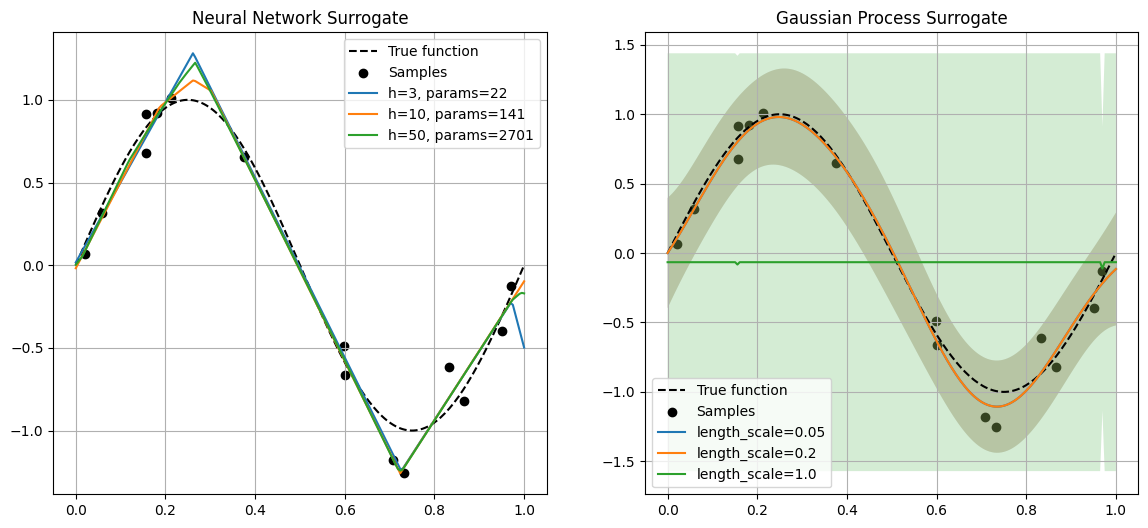

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# -----------------------------
# 1. Define the ground truth function
# -----------------------------
def f(x):
    return np.sin(2 * np.pi * x)

# -----------------------------
# 2. Sample 15 noisy data points
# -----------------------------
np.random.seed(42)
X_train = np.random.uniform(0, 1, 15)
y_train = f(X_train) + 0.1 * np.random.randn(15)

X_tensor = torch.tensor(X_train.reshape(-1,1), dtype=torch.float32)
y_tensor = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)

X_test = np.linspace(0,1,200).reshape(-1,1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# -----------------------------
# 3. Neural Network helper
# -----------------------------
def train_nn(hidden_size, n_epochs=2000):
    model = nn.Sequential(
        nn.Linear(1, hidden_size),
        nn.Linear(hidden_size,hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1),
    )
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        y_pred = model(X_tensor)
        loss = loss_fn(y_pred, y_tensor)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).numpy()
    return y_pred_test, sum(p.numel() for p in model.parameters())

# -----------------------------
# 4. Gaussian Process helper
# -----------------------------
def fit_gp(length_scale):
    kernel = RBF(length_scale=length_scale) + WhiteKernel(noise_level=0.01)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
    gp.fit(X_train.reshape(-1,1), y_train)
    y_pred_gp, y_std_gp = gp.predict(X_test, return_std=True)
    return y_pred_gp, y_std_gp

# -----------------------------
# 5. Plot Neural Networks with different sizes
# -----------------------------
nn_sizes = [3, 10, 50]
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(X_test, f(X_test), 'k--', label='True function')
plt.scatter(X_train, y_train, color='black', label='Samples')

for h in nn_sizes:
    y_pred_nn, n_params = train_nn(h)
    plt.plot(X_test, y_pred_nn, label=f'h={h}, params={n_params}')

plt.title("Neural Network Surrogate")
plt.legend()
plt.grid(True)

# -----------------------------
# 6. Plot Gaussian Processes with different kernels
# -----------------------------
gp_lengths = [0.05, 0.2, 1.0]
plt.subplot(1,2,2)
plt.plot(X_test, f(X_test), 'k--', label='True function')
plt.scatter(X_train, y_train, color='black', label='Samples')

for ls in gp_lengths:
    y_pred_gp, y_std_gp = fit_gp(ls)
    plt.plot(X_test, y_pred_gp, label=f'length_scale={ls}')
    plt.fill_between(
        X_test.ravel(),
        y_pred_gp - 2*y_std_gp,
        y_pred_gp + 2*y_std_gp,
        alpha=0.2
    )

plt.title("Gaussian Process Surrogate")
plt.legend()
plt.grid(True)
plt.show()